In [1]:
%pip install influxdb-client mplfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


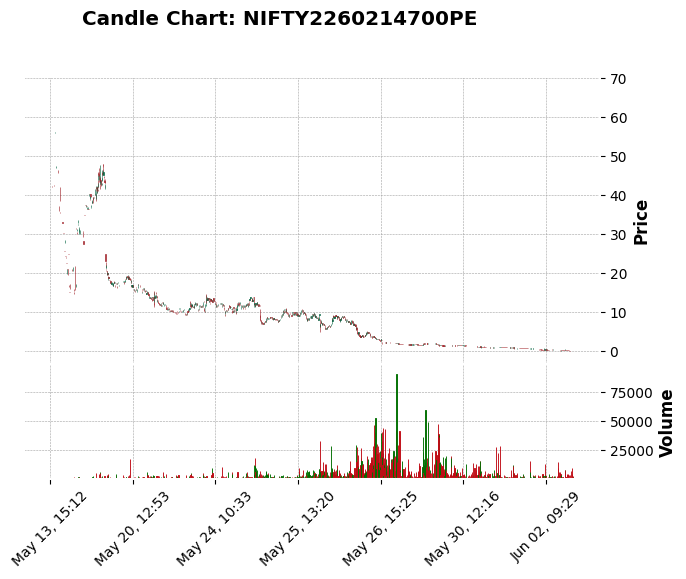

,Open,High,Low,Close,Volume
_time,,,,,
2022-05-13 15:12:59+00:00,67.05,67.05,67.05,67.05,500
2022-05-13 15:13:59+00:00,63.60,63.60,63.55,63.60,550
2022-05-13 15:14:59+00:00,64.45,64.45,64.45,64.45,250
2022-05-13 15:15:59+00:00,64.20,64.20,64.20,64.20,250
2022-05-13 15:24:59+00:00,60.00,60.00,60.00,60.00,100


In [16]:
import pandas as pd
import mplfinance as mpf
from influxdb_client import InfluxDBClient
from datetime import datetime
from PyTrasy.SECRETS import INFLUXDB_TOKEN, INFLUX_ORG, INFLUX_URL

# InfluxDB connection details
BUCKET_NAME = "Historical Data"

# Initialize the InfluxDB client
client = InfluxDBClient(url=INFLUX_URL, token=INFLUXDB_TOKEN, org=INFLUX_ORG)
query_api = client.query_api()

# Define the Flux query to get data for the specific FileSymbol
query = f'''
from(bucket: "{BUCKET_NAME}")
  |> range(start: 2022-01-01T00:00:00Z, stop: 2023-01-01T00:00:00Z)
  |> filter(fn: (r) => r["_measurement"] == "futures_data")
  |> filter(fn: (r) => r["FileSymbol"] == "NIFTY2260214700PE")
  |> filter(fn: (r) => r["_field"] == "Open" or r["_field"] == "High" or r["_field"] == "Low" or r["_field"] == "Close" or r["_field"] == "Volume")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''

# Execute the query and retrieve the data
result = query_api.query_data_frame(org=INFLUX_ORG, query=query)

# Ensure the DataFrame has the correct types and index
result['_time'] = pd.to_datetime(result['_time'])
result.set_index('_time', inplace=True)
result = result[['Open', 'High', 'Low', 'Close', 'Volume']]

# Convert Volume to integer if necessary
result['Volume'] = result['Volume'].astype(int)

# Plot the candle chart with volume using mplfinance
mpf.plot(result, type='candle', volume=True, style='charles', title='Candle Chart: NIFTY2260214700PE', ylabel='Price', ylabel_lower='Volume')

# Display the DataFrame (optional)
result.head()


In [14]:
import pandas as pd
from influxdb_client import InfluxDBClient
from IPython.display import display, HTML, Javascript
import json
from PyTrasy.SECRETS import INFLUXDB_TOKEN, INFLUX_ORG, INFLUX_URL

# InfluxDB connection details
BUCKET_NAME = "Historical Data"

# Initialize the InfluxDB client
client = InfluxDBClient(url=INFLUX_URL, token=INFLUXDB_TOKEN, org=INFLUX_ORG)
query_api = client.query_api()

# Define the Flux query to get data for the specific FileSymbol
query = f'''
from(bucket: "{BUCKET_NAME}")
  |> range(start: 2022-01-01T00:00:00Z, stop: 2023-01-01T00:00:00Z)
  |> filter(fn: (r) => r["_measurement"] == "futures_data")
  |> filter(fn: (r) => r["FileSymbol"] == "NIFTY2260214700PE")
  |> filter(fn: (r) => r["_field"] == "Open" or r["_field"] == "High" or r["_field"] == "Low" or r["_field"] == "Close" or r["_field"] == "Volume")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''

# Execute the query and retrieve the data
result = query_api.query_data_frame(org=INFLUX_ORG, query=query)

# Ensure the DataFrame has the correct types and index
result['_time'] = pd.to_datetime(result['_time'])
result.set_index('_time', inplace=True)
result = result[['Open', 'High', 'Low', 'Close', 'Volume']]

# Prepare the data for Lightweight Charts
candle_data = []
volume_data = []
for index, row in result.iterrows():
    candle_data.append({
        'time': int(index.timestamp()),
        'open': row['Open'],
        'high': row['High'],
        'low': row['Low'],
        'close': row['Close']
    })
    volume_data.append({
        'time': int(index.timestamp()),
        'value': row['Volume']
    })

# Display the chart
html_template = f'''
<div id="chart" style="width: 100%; height: 500px;"></div>
<script src="https://unpkg.com/lightweight-charts/dist/lightweight-charts.standalone.production.js"></script>
<script>
    var chart = LightweightCharts.createChart(document.getElementById('chart'), {{
        width: document.getElementById('chart').clientWidth,
        height: 500,
        layout: {{
            backgroundColor: '#ffffff',
            textColor: '#000000',
        }},
        grid: {{
            vertLines: {{
                color: '#e1e1e1',
            }},
            horzLines: {{
                color: '#e1e1e1',
            }},
        }},
        crosshair: {{
            mode: LightweightCharts.CrosshairMode.Normal,
        }},
        priceScale: {{
            borderColor: '#cccccc',
        }},
        timeScale: {{
            borderColor: '#cccccc',
            timeVisible: true,
            secondsVisible: true,
        }},
    }});

    var candleSeries = chart.addCandlestickSeries({{
        upColor: '#4CAF50',
        downColor: '#FF5252',
        borderDownColor: '#FF5252',
        borderUpColor: '#4CAF50',
        wickDownColor: '#FF5252',
        wickUpColor: '#4CAF50',
    }});

    var volumeSeries = chart.addHistogramSeries({{
        color: '#26a69a',
        lineWidth: 2,
        priceFormat: {{
            type: 'volume',
        }},
        overlay: true,
        scaleMargins: {{
            top: 0.8,
            bottom: 0,
        }},
    }});

    candleSeries.setData({json.dumps(candle_data)});
    volumeSeries.setData({json.dumps(volume_data)});
</script>
'''

display(HTML(html_template))


In [14]:
%pip install lightweight-charts

  Using cached pythonnet-3.0.3-py3-none-any.whl.metadata (6.6 kB)
  Using cached clr_loader-0.2.6-py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/95.6 kB ? eta -:--:--
   ------------------------- -------------- 61.4/95.6 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 95.6/95.6 kB 2.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/446.1 kB ? eta -:--:--
   ---------------- ----------------------- 184.3/446.1 kB 5.6 MB/s eta 0:00:01
   ---------------------------- ----------- 317.4/446.1 kB 3.9 MB/s eta 0:00:01
   ---------------------------- ----------- 317.4/446.1 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 446.1/446.1 kB 3.1 MB/s eta 0:00:00
Using cached pythonnet-3.0.3-py3-none-any.whl (290 kB)
Using cached clr_loader-0.2.6-py3-none-any.whl (51 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from lightweight_charts import Chart

# Define the Flux query to get data for the specific FileSymbol
query = f'''
from(bucket: "{BUCKET_NAME}")
  |> range(start: 2022-01-01T00:00:00Z, stop: 2023-01-01T00:00:00Z)
  |> filter(fn: (r) => r["_measurement"] == "futures_data")
  |> filter(fn: (r) => r["FileSymbol"] == "NIFTY2260214700PE")
  |> filter(fn: (r) => r["_field"] == "Open" or r["_field"] == "High" or r["_field"] == "Low" or r["_field"] == "Close" or r["_field"] == "Volume")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''

# Execute the query and retrieve the data
result = query_api.query_data_frame(org=INFLUX_ORG, query=query)

# Ensure the DataFrame has the correct types and index
result['_time'] = pd.to_datetime(result['_time'])
result.set_index('_time', inplace=True)
result = result[['Open', 'High', 'Low', 'Close', 'Volume']]

# Prepare the data for Lightweight Charts
data = result.reset_index()
data['time'] = data['_time'].apply(lambda x: x.isoformat())
data = data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})
data = data[['time', 'open', 'high', 'low', 'close', 'volume']]

# Create the chart
chart = Chart()

# Set the data for the chart
chart.set(data)

# Show the chart
chart.show(block=True)


AssertionError: cannot start a process twice

: 